In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from random import shuffle
import sklearn
from sklearn.utils import shuffle
import seaborn as sns
import pickle
import os
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

Data Collection

In [7]:
def all_listed_stocks(start_date, end_date):
    sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    last_tickers = sp500[0]['Symbol'].tolist()
    old_tickers = sp500[1].Removed.Ticker.unique()
    all_tickers = list(set(list(last_tickers) + list(old_tickers)))
    #changed to only current tickers
    print('Over the period', len(last_tickers), ' different stocks were part of the SnP')
    return last_tickers

def get_data_batch(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            data[ticker] = stock.history(start=start_date, end=end_date)
        except:
            print(f"Failed to fetch data for {ticker}")
    return data

def get_non_empty_data(dico):
    non_empty_data = {}
    for ticker, df in dico.items():
        if not df.empty:
            non_empty_data[ticker] = df
    return non_empty_data

def tickers_with_nan(dico):
    non_empty_full_data = get_non_empty_data(dico)
    tickers_with_nan = []
    for ticker in non_empty_full_data.keys():
        if non_empty_full_data[ticker].isna().any().any():
            tickers_with_nan.append(ticker)

    if tickers_with_nan:
        print(f"Tickers with some NaN : {tickers_with_nan}")
    else:
        print("No tickers contains any NaN.")

Generating Signals and Images 

In [8]:
def create_candlestick_image(ohlc_data, size=(30, 30)):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_axis_off()

    indices = np.arange(len(ohlc_data))
    up = ohlc_data[ohlc_data['Close'] >= ohlc_data['Open']]
    down = ohlc_data[ohlc_data['Close'] < ohlc_data['Open']]

    up_indices = np.where(ohlc_data['Close'] >= ohlc_data['Open'])[0]
    down_indices = np.where(ohlc_data['Close'] < ohlc_data['Open'])[0]

    # Plot up candles
    ax.bar(up_indices, up['Close'] - up['Open'], 0.6, bottom=up['Open'], color='white', edgecolor='black')
    ax.vlines(up_indices, up['Low'], up['Open'], color='black', linewidth=1)
    ax.vlines(up_indices, up['Close'], up['High'], color='black', linewidth=1)

    # Plot down candles
    ax.bar(down_indices, down['Close'] - down['Open'], 0.6, bottom=down['Open'], color='black', edgecolor='black')
    ax.vlines(down_indices, down['Low'], down['Open'], color='black', linewidth=1)
    ax.vlines(down_indices, down['Close'], down['High'], color='black', linewidth=1)


    buffer = BytesIO()
    plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight', pad_inches=0)
    buffer.seek(0)
    image = Image.open(buffer)

    image = image.resize(size, Image.LANCZOS)
    plt.close()

    return np.array(image.convert('L'))


def calculate_bb(data, window=20, num_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return pd.DataFrame({'Upper': upper_band, 'Lower': lower_band, 'Close': data['Close']})


def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))


def calculate_macd(data, fast=12, slow=26, signal=9):
    exp1 = data['Close'].ewm(span=fast, adjust=False).mean()
    exp2 = data['Close'].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return pd.DataFrame({'MACD': macd, 'Signal': signal_line})


def generate_labels(data):
    bb = calculate_bb(data)
    rsi = calculate_rsi(data)
    macd = calculate_macd(data)

    bb_label = (data['Close'] > bb['Lower']).astype(int)
    rsi_label = (rsi > 30).astype(int)
    macd_label = ((macd['MACD'] > macd['Signal']) & (macd['MACD'].shift(1) <= macd['Signal'].shift(1))).astype(int)
    #above we put a positive signal only when the MACD lines CROSSES the signal line, gowing up.

    return pd.DataFrame({'BB': bb_label, 'RSI': rsi_label, 'MACD': macd_label})


def generate_sell_labels(data):
    bb = calculate_bb(data)
    rsi = calculate_rsi(data)
    macd = calculate_macd(data)

    bb_label = (data['Close'] > bb['Upper']).astype(int)
    rsi_label = (rsi > 70).astype(int)
    macd_label = ((macd['MACD'] < macd['Signal']) & (macd['MACD'].shift(1) >= macd['Signal'].shift(1))).astype(int)

    return pd.DataFrame({'BB': bb_label, 'RSI': rsi_label, 'MACD': macd_label})


def extract_ohlc_windows(data, samples_per_class=10, window_size_bb=20, window_size_macd=26, window_size_rsi=27):
    ohlc_windows = {
        'BB': {'buy': [], 'no_buy': []},
        'RSI': {'buy': [], 'no_buy': []},
        'MACD': {'buy': [], 'no_buy': []}
    }

    for ticker, df in data.items():
        df_labels = generate_labels(df)

        for indicator in ['BB', 'RSI', 'MACD']:
            if indicator == 'BB':
                window_size = window_size_bb
            elif indicator == 'MACD':
                window_size = window_size_macd
            elif indicator == 'RSI':
                window_size = window_size_rsi

            buy_indices = df_labels[df_labels[indicator] == 1].index
            no_buy_indices = df_labels[df_labels[indicator] == 0].index

            buy_samples = np.random.choice(buy_indices, min(samples_per_class, len(buy_indices)), replace=False)
            no_buy_samples = np.random.choice(no_buy_indices, min(samples_per_class, len(no_buy_indices)), replace=False)

            for idx in buy_samples:
                if df.index.get_loc(idx) >= window_size:
                    ohlc_window = df.loc[idx-pd.Timedelta(days=window_size):idx]
                    ohlc_windows[indicator]['buy'].append(ohlc_window)

            for idx in no_buy_samples:
                if df.index.get_loc(idx) >= window_size:
                    ohlc_window = df.loc[idx-pd.Timedelta(days=window_size):idx]
                    ohlc_windows[indicator]['no_buy'].append(ohlc_window)

    return ohlc_windows


def generate_images_from_ohlc(ohlc_windows, size=(30, 30), max_samples=5000):
    images = {
        'BB': {'buy': [], 'no_buy': []},
        'RSI': {'buy': [], 'no_buy': []},
        'MACD': {'buy': [], 'no_buy': []}
    }

    for indicator in ohlc_windows.keys():
        for label in ['buy', 'no_buy']:
            count = 0
            for ohlc_window in ohlc_windows[indicator][label]:
                #if count >= max_samples:
                #    break
                image = create_candlestick_image(ohlc_window, size=size)
                images[indicator][label].append(image)
                count += 1

    return images


Visualisng the Signals 

In [9]:
def plot_signals_with_indicators(data):

    plt.style.use('default')

    bb = calculate_bb(data)
    rsi = calculate_rsi(data)
    macd_data = calculate_macd(data)

    fig, axes = plt.subplots(3, 1, figsize=(15, 8))

    # 1. Bollinger Bands
    axes[0].plot(bb.index, bb['Close'], label='Close', color='black', linewidth=1.5)
    axes[0].plot(bb.index, bb['Upper'], label='Upper Band', color='red', linestyle='--')
    axes[0].plot(bb.index, bb['Lower'], label='Lower Band', color='blue', linestyle='--')
    axes[0].fill_between(bb.index, bb['Lower'], bb['Upper'], color='gray', alpha=0.2)
    axes[0].set_title('Bollinger Bands', fontsize=14)
    axes[0].legend(loc='upper left')
    axes[0].set_ylabel('Price')
    axes[0].grid(True)

    # 2. RSI
    axes[1].plot(rsi.index, rsi, label='RSI', color='purple', linewidth=1.5)
    axes[1].axhline(30, color='red', linestyle='--', label='Oversold (30)')
    axes[1].axhline(70, color='green', linestyle='--', label='Overbought (70)')
    axes[1].set_title('Relative Strength Index (RSI)', fontsize=14)
    axes[1].legend(loc='upper left')
    axes[1].set_ylabel('RSI Value')
    axes[1].grid(True)

    # 3. MACD
    axes[2].plot(macd_data.index, macd_data['MACD'], label='MACD', color='orange', linewidth=1.5)
    axes[2].plot(macd_data.index, macd_data['Signal'], label='Signal Line', color='blue', linewidth=1.5)
    axes[2].fill_between(macd_data.index, macd_data['MACD'] - macd_data['Signal'], color='gray', alpha=0.3, label='MACD - Signal')
    axes[2].set_title('MACD', fontsize=14)
    axes[2].legend(loc='upper left')
    axes[2].set_ylabel('Value')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


Processing and loading data 

In [10]:
def process_batch(data_batch, output_dir, batch_num, data_type, samples_per_class=10):
    ohlc_windows = extract_ohlc_windows(data_batch, samples_per_class)
    images = generate_images_from_ohlc(ohlc_windows)
    for indicator in images.keys():
        for label in ['buy', 'no_buy']:
            filename = f"{indicator}_{label}_{data_type}_batch_{batch_num}.pkl"
            filepath = os.path.join(output_dir, filename)
            with open(filepath, 'wb') as f:
                pickle.dump(images[indicator][label], f)
    print(f"Batch {batch_num} ({data_type}) processed and saved.")

def load_batches(directory, data_type):
    all_images = {
        'BB': {'buy': [], 'no_buy': []},
        'RSI': {'buy': [], 'no_buy': []},
        'MACD': {'buy': [], 'no_buy': []}
    }
    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            parts = filename.split('_')
            if len(parts) >= 4 and parts[-2] == 'batch' and parts[-3] == data_type:
                indicator = parts[0]
                label = 'buy' if parts[1] == 'buy' else 'no_buy'
                if indicator in all_images and label in all_images[indicator]:
                    with open(os.path.join(directory, filename), 'rb') as f:
                        batch_images = pickle.load(f)
                        all_images[indicator][label].extend(batch_images)
                else:
                    print(f"Skipping unexpected file: {filename}")
            else:
                print(f"Skipping file with unexpected format: {filename}")
    return all_images

def process_data(tickers, start_date, end_date, output_dir, data_type, batch_size=100):
    for i in range(0, len(tickers), batch_size):
        batch_tickers = tickers[i:i+batch_size]
        print(f"Processing {data_type} batch {i//batch_size + 1}")
        data_batch = get_data_batch(batch_tickers, start_date, end_date)
        process_batch(data_batch, output_dir, i//batch_size + 1, data_type)

In [11]:
# Define the date ranges
train_start = '2010-01-01'
train_end = '2014-12-31'
val_start = '2015-01-01'
val_end = '2017-12-31'
test_start = '2018-01-01'
test_end = '2019-12-31'
batch_size = 50  # Process 50 stocks at a time
output_dir = 'ohlc_images_batches'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    

In [12]:
all_tickers = all_listed_stocks( train_start, test_end)
sample_tickers = all_tickers[:10]
data_sample = get_data_batch(sample_tickers, train_start, train_end)
sample_tickers[0]

Over the period 503  different stocks were part of the SnP


'MMM'

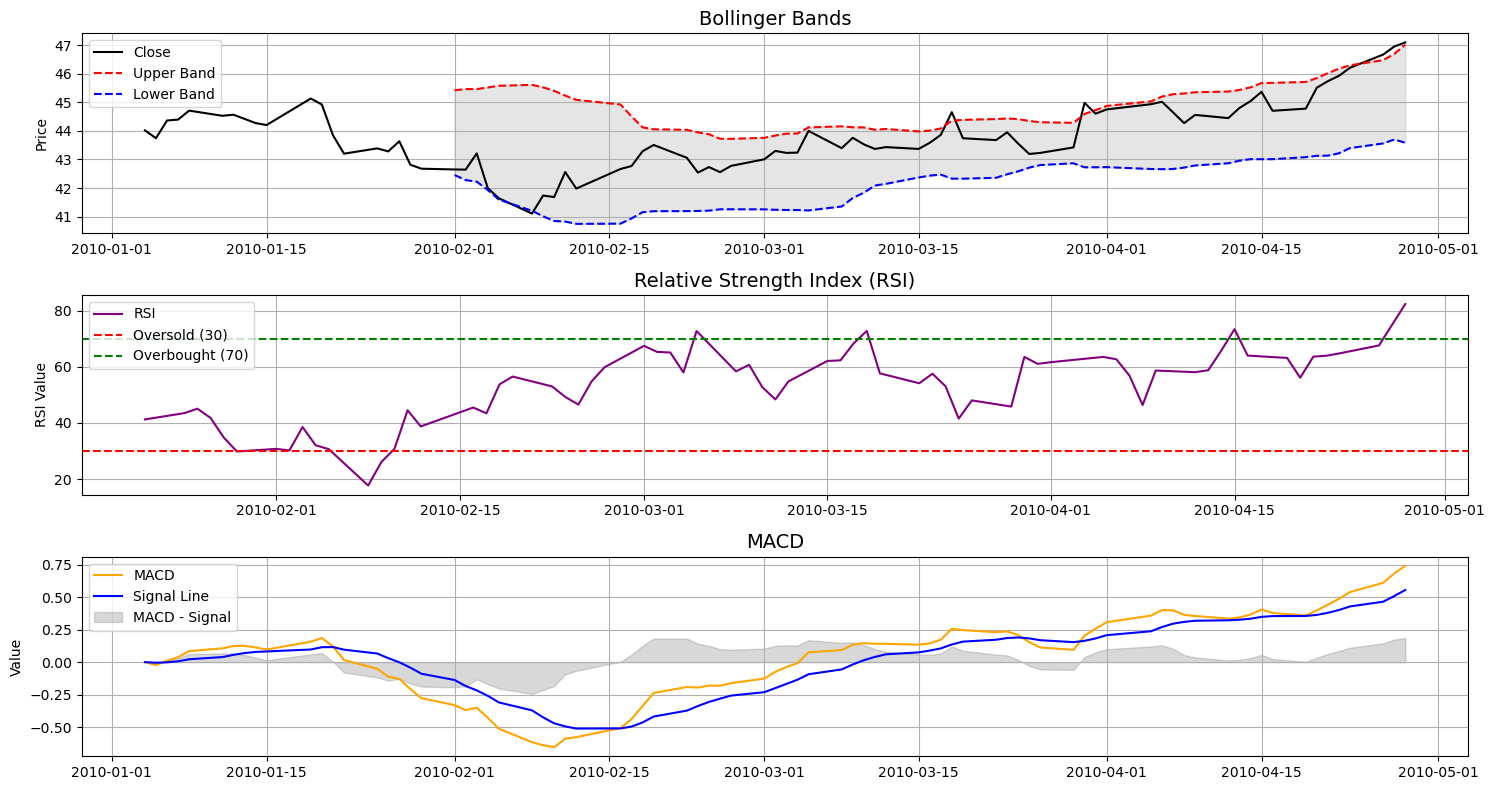

In [13]:
plot_signals_with_indicators(data_sample['MMM'][:80])

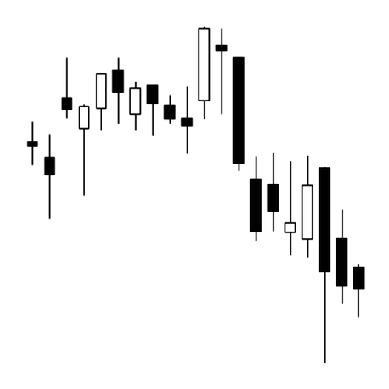

In [14]:
candlestick_image = create_candlestick_image(data_sample['MMM'][:20], size=(500, 500))
plt.imshow(candlestick_image, cmap='gray', interpolation='nearest')
plt.axis('off')  
plt.show()

Training Data

In [15]:
#process_data(all_tickers, train_start, train_end, 'ohlc_images_batches', 'train')
#process_data(all_tickers, val_start, val_end, 'ohlc_images_batches', 'val')
process_data(all_tickers, test_start, test_end, 'ohlc_images_batches', 'test')

Processing test batch 1


ABNB: Data doesn't exist for startDate = 1514782800, endDate = 1577768400
BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 2018-01-01 -> 2019-12-31)
CARR: Data doesn't exist for startDate = 1514782800, endDate = 1577768400


Batch 1 (test) processed and saved.
Processing test batch 2


CEG: Data doesn't exist for startDate = 1514782800, endDate = 1577768400


Batch 2 (test) processed and saved.
Processing test batch 3


GEHC: Data doesn't exist for startDate = 1514782800, endDate = 1577768400
GEV: Data doesn't exist for startDate = 1514782800, endDate = 1577768400
KVUE: Data doesn't exist for startDate = 1514782800, endDate = 1577768400


Batch 3 (test) processed and saved.
Processing test batch 4


OTIS: Data doesn't exist for startDate = 1514782800, endDate = 1577768400
PLTR: Data doesn't exist for startDate = 1514782800, endDate = 1577768400


Batch 4 (test) processed and saved.
Processing test batch 5


SW: Data doesn't exist for startDate = 1514782800, endDate = 1577768400
SOLV: Data doesn't exist for startDate = 1514782800, endDate = 1577768400
VLTO: Data doesn't exist for startDate = 1514782800, endDate = 1577768400


Batch 5 (test) processed and saved.
Processing test batch 6
Batch 6 (test) processed and saved.


In [16]:
try:
    training_data = load_batches('ohlc_images_batches', 'train')
    validation_data = load_batches('ohlc_images_batches', 'val')
    testing_data = load_batches('ohlc_images_batches', 'test')
    
    print("Data loaded successfully.")
    # Print some information about the loaded data
    for data_set, name in [(training_data, "Training"), (validation_data, "Validation"), (testing_data, "Testing")]:
        print(f"\n{name} Data:")
        for indicator in data_set:
            for label in data_set[indicator]:
                print(f"{indicator} - {label}: {len(data_set[indicator][label])} images")
except Exception as e:
    print(f"An error occurred while loading the data: {str(e)}")

Data loaded successfully.

Training Data:
BB - buy: 4683 images
BB - no_buy: 3326 images
RSI - buy: 4635 images
RSI - no_buy: 3844 images
MACD - buy: 4492 images
MACD - no_buy: 4572 images

Validation Data:
BB - buy: 4806 images
BB - no_buy: 2986 images
RSI - buy: 4722 images
RSI - no_buy: 3854 images
MACD - buy: 4561 images
MACD - no_buy: 4655 images

Testing Data:
BB - buy: 4893 images
BB - no_buy: 2634 images
RSI - buy: 4772 images
RSI - no_buy: 3555 images
MACD - buy: 4564 images
MACD - no_buy: 4653 images


Implement various classifiers and the ensemble model

In [17]:
def prepare_data(data, indicator):
    X = []
    y = []
    for label in data[indicator]:
        X.extend(data[indicator][label])
        y.extend([1 if label == 'buy' else 0] * len(data[indicator][label]))
    return np.array(X), np.array(y)

def create_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, indicator):
    # Reshape the data for traditional ML models
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    X_val_2d = X_val.reshape(X_val.shape[0], -1)
    X_test_2d = X_test.reshape(X_test.shape[0], -1)

    # Standardize the data
    scaler = StandardScaler()
    X_train_2d = scaler.fit_transform(X_train_2d)
    X_val_2d = scaler.transform(X_val_2d)
    X_test_2d = scaler.transform(X_test_2d)

    # Define classifiers
    classifiers = {
        'Logistic Regression': LogisticRegression(),
        'Gaussian Naive Bayes': GaussianNB(),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
        'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(),
        'Gaussian Process': GaussianProcessClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Linear SVM': SVC(kernel='linear'),
        'RBF SVM': SVC(kernel='rbf'),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Extra Trees': ExtraTreesClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'Bagging': BaggingClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'Neural Net': MLPClassifier(hidden_layer_sizes=(32, 32, 32))
    }

    results = {}
    for name, clf in classifiers.items():
        print(f"Training {name} for {indicator}...")
        clf.fit(X_train_2d, y_train)
        y_pred = clf.predict(X_test_2d)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        results[name] = {'accuracy': accuracy, 'precision': precision}
        print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")

    # Train and evaluate CNN
    cnn = create_cnn()
    cnn.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)
    y_pred_cnn = (cnn.predict(X_test) > 0.5).astype(int)
    cnn_accuracy = accuracy_score(y_test, y_pred_cnn)
    cnn_precision = precision_score(y_test, y_pred_cnn, average='weighted')
    results['CNN'] = {'accuracy': cnn_accuracy, 'precision': cnn_precision}
    print(f"CNN - Accuracy: {cnn_accuracy:.4f}, Precision: {cnn_precision:.4f}")

    # Create ensemble model (excluding CNN)
    estimators = [(name, clf) for name, clf in classifiers.items()]
    ensemble = VotingClassifier(estimators=estimators, voting='hard')

    # Train and evaluate ensemble
    ensemble.fit(X_train_2d, y_train)
    y_pred_ensemble = ensemble.predict(X_test_2d)
    ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
    ensemble_precision = precision_score(y_test, y_pred_ensemble, average='weighted')
    results['Ensemble'] = {'accuracy': ensemble_accuracy, 'precision': ensemble_precision}
    print(f"Ensemble - Accuracy: {ensemble_accuracy:.4f}, Precision: {ensemble_precision:.4f}")

    # Perform cross-validation
    cv_scores = cross_val_score(ensemble, X_train_2d, y_train, cv=5)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return results


In [18]:
indicators = ['BB', 'RSI', 'MACD']
all_results = {}

for indicator in indicators:
    print(f"\nProcessing {indicator}")
    
    # Prepare data for each set
    X_train, y_train = prepare_data(training_data, indicator)
    X_val, y_val = prepare_data(validation_data, indicator)
    X_test, y_test = prepare_data(testing_data, indicator)

    # Train and evaluate models
    results = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, indicator)
    all_results[indicator] = results

# Print final results
for indicator in indicators:
    print(f"\nFinal results for {indicator}:")
    for model, metrics in all_results[indicator].items():
        print(f"{model} - Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}")


Processing BB
Training Logistic Regression for BB...


/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Accuracy: 0.9390, Precision: 0.9399
Training Gaussian Naive Bayes for BB...
Gaussian Naive Bayes - Accuracy: 0.9077, Precision: 0.9195
Training Linear Discriminant Analysis for BB...
Linear Discriminant Analysis - Accuracy: 0.9393, Precision: 0.9418
Training Quadratic Discriminant Analysis for BB...


/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Quadratic Discriminant Analysis - Accuracy: 0.9024, Precision: 0.9103
Training Gaussian Process for BB...
Gaussian Process - Accuracy: 0.8224, Precision: 0.8520
Training K-Nearest Neighbors for BB...
K-Nearest Neighbors - Accuracy: 0.8450, Precision: 0.8815
Training Linear SVM for BB...
Linear SVM - Accuracy: 0.9306, Precision: 0.9317
Training RBF SVM for BB...
RBF SVM - Accuracy: 0.9560, Precision: 0.9579
Training Decision Tree for BB...
Decision Tree - Accuracy: 0.9135, Precision: 0.9151
Training Random Forest for BB...
Random Forest - Accuracy: 0.9574, Precision: 0.9591
Training Extra Trees for BB...
Extra Trees - Accuracy: 0.9583, Precision: 0.9601
Training AdaBoost for BB...


/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost - Accuracy: 0.9462, Precision: 0.9471
Training Bagging for BB...
Bagging - Accuracy: 0.9458, Precision: 0.9484
Training Gradient Boosting for BB...
Gradient Boosting - Accuracy: 0.9559, Precision: 0.9575
Training Neural Net for BB...
Neural Net - Accuracy: 0.9498, Precision: 0.9504


/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8096 - loss: 0.8535 - val_accuracy: 0.9059 - val_loss: 0.2702
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9215 - loss: 0.1956 - val_accuracy: 0.9057 - val_loss: 0.2614
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9296 - loss: 0.1824 - val_accuracy: 0.9277 - val_loss: 0.2036
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9334 - loss: 0.1629 - val_accuracy: 0.9357 - val_loss: 0.1739
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9460 - loss: 0.1421 - val_accuracy: 0.9351 - val_loss: 0.1834
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9515 - loss: 0.1308 - val_accuracy: 0.9438 - val_loss: 0.1613
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9516 - loss: 0.1255 - val_accuracy: 0.9414 - val_loss: 0.1786
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9531 - loss: 0.1184 - val_accu

/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.war

Ensemble - Accuracy: 0.9570, Precision: 0.9596


/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.war

Cross-validation scores: [0.95193508 0.95692884 0.96129838 0.9619226  0.94440974]
Mean CV score: 0.9553 (+/- 0.0130)

Processing RSI
Training Logistic Regression for RSI...


/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Accuracy: 0.8952, Precision: 0.8960
Training Gaussian Naive Bayes for RSI...
Gaussian Naive Bayes - Accuracy: 0.8508, Precision: 0.8692
Training Linear Discriminant Analysis for RSI...
Linear Discriminant Analysis - Accuracy: 0.8980, Precision: 0.9032
Training Quadratic Discriminant Analysis for RSI...


/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Quadratic Discriminant Analysis - Accuracy: 0.8717, Precision: 0.8741
Training Gaussian Process for RSI...
Gaussian Process - Accuracy: 0.7908, Precision: 0.8206
Training K-Nearest Neighbors for RSI...
K-Nearest Neighbors - Accuracy: 0.8044, Precision: 0.8529
Training Linear SVM for RSI...
Linear SVM - Accuracy: 0.8895, Precision: 0.8907
Training RBF SVM for RSI...
RBF SVM - Accuracy: 0.9228, Precision: 0.9270
Training Decision Tree for RSI...
Decision Tree - Accuracy: 0.8829, Precision: 0.8841
Training Random Forest for RSI...
Random Forest - Accuracy: 0.9333, Precision: 0.9366
Training Extra Trees for RSI...
Extra Trees - Accuracy: 0.9306, Precision: 0.9346
Training AdaBoost for RSI...


/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost - Accuracy: 0.9186, Precision: 0.9197
Training Bagging for RSI...
Bagging - Accuracy: 0.9218, Precision: 0.9256
Training Gradient Boosting for RSI...
Gradient Boosting - Accuracy: 0.9344, Precision: 0.9369
Training Neural Net for RSI...
Neural Net - Accuracy: 0.9213, Precision: 0.9221
Epoch 1/10


/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7262 - loss: 1.8192 - val_accuracy: 0.8685 - val_loss: 0.3000
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8844 - loss: 0.2965 - val_accuracy: 0.8737 - val_loss: 0.2969
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9051 - loss: 0.2400 - val_accuracy: 0.8857 - val_loss: 0.2688
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9017 - loss: 0.2495 - val_accuracy: 0.8730 - val_loss: 0.2879
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9052 - loss: 0.2344 - val_accuracy: 0.8888 - val_loss: 0.2565
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9074 - loss: 0.2198 - val_accuracy: 0.9049 - val_loss: 0.2350
Epoch 7/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9182 - loss: 0.1997 - val_accuracy: 0.8966 - val_loss: 0.2690
Epoch 8/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9123 - loss: 0.2054 - val_accuracy: 0.901

/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.war

Ensemble - Accuracy: 0.9267, Precision: 0.9318


/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.war

Cross-validation scores: [0.93691038 0.9321934  0.92158019 0.93337264 0.93156342]
Mean CV score: 0.9311 (+/- 0.0102)

Processing MACD
Training Logistic Regression for MACD...


/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Accuracy: 0.7497, Precision: 0.7499
Training Gaussian Naive Bayes for MACD...
Gaussian Naive Bayes - Accuracy: 0.7354, Precision: 0.7404
Training Linear Discriminant Analysis for MACD...
Linear Discriminant Analysis - Accuracy: 0.7462, Precision: 0.7466
Training Quadratic Discriminant Analysis for MACD...
Quadratic Discriminant Analysis - Accuracy: 0.7349, Precision: 0.7358
Training Gaussian Process for MACD...
Gaussian Process - Accuracy: 0.6597, Precision: 0.6599
Training K-Nearest Neighbors for MACD...
K-Nearest Neighbors - Accuracy: 0.6990, Precision: 0.7050
Training Linear SVM for MACD...
Linear SVM - Accuracy: 0.7525, Precision: 0.7529
Training RBF SVM for MACD...
RBF SVM - Accuracy: 0.7936, Precision: 0.7963
Training Decision Tree for MACD...
Decision Tree - Accuracy: 0.7016, Precision: 0.7016
Training Random Forest for MACD...
Random Forest - Accuracy: 0.8007, Precision: 0.8017
Training Extra Trees for MACD...
Extra Trees - Accuracy: 0.8031, Precision: 0.8

/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost - Accuracy: 0.7649, Precision: 0.7649
Training Bagging for MACD...
Bagging - Accuracy: 0.7716, Precision: 0.7722
Training Gradient Boosting for MACD...
Gradient Boosting - Accuracy: 0.7941, Precision: 0.7949
Training Neural Net for MACD...
Neural Net - Accuracy: 0.7598, Precision: 0.7598
Epoch 1/10


/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


284/284 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5771 - loss: 1.7954 - val_accuracy: 0.6201 - val_loss: 0.6583
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6710 - loss: 0.6244 - val_accuracy: 0.6680 - val_loss: 0.6426
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6975 - loss: 0.5865 - val_accuracy: 0.6814 - val_loss: 0.6026
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7106 - loss: 0.5692 - val_accuracy: 0.7156 - val_loss: 0.5778
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7300 - loss: 0.5466 - val_accuracy: 0.7326 - val_loss: 0.5542
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7532 - loss: 0.5141 - val_accuracy: 0.7374 - val_loss: 0.5388
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7612 - loss: 0.4955 - val_accuracy: 0.7387 - val_loss: 0.5291
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7459 - loss: 0.5118 - val_accuracy: 0.723

/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Ensemble - Accuracy: 0.7957, Precision: 0.7975


/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/rashimohta/anaconda3/envs/mfe230e/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

Cross-validation scores: [0.80584666 0.78599007 0.79757308 0.8130171  0.80684327]
Mean CV score: 0.8019 (+/- 0.0187)

Final results for BB:
Logistic Regression - Accuracy: 0.9390, Precision: 0.9399
Gaussian Naive Bayes - Accuracy: 0.9077, Precision: 0.9195
Linear Discriminant Analysis - Accuracy: 0.9393, Precision: 0.9418
Quadratic Discriminant Analysis - Accuracy: 0.9024, Precision: 0.9103
Gaussian Process - Accuracy: 0.8224, Precision: 0.8520
K-Nearest Neighbors - Accuracy: 0.8450, Precision: 0.8815
Linear SVM - Accuracy: 0.9306, Precision: 0.9317
RBF SVM - Accuracy: 0.9560, Precision: 0.9579
Decision Tree - Accuracy: 0.9135, Precision: 0.9151
Random Forest - Accuracy: 0.9574, Precision: 0.9591
Extra Trees - Accuracy: 0.9583, Precision: 0.9601
AdaBoost - Accuracy: 0.9462, Precision: 0.9471
Bagging - Accuracy: 0.9458, Precision: 0.9484
Gradient Boosting - Accuracy: 0.9559, Precision: 0.9575
Neural Net - Accuracy: 0.9498, Precision: 0.9504
CNN - Accuracy: 0.9431, Precision: 0.9438
Ense

In [27]:
all_results
results = []
for label, models in all_results.items():
    for model_name, metrics in models.items():
        results.append({
            'Label': label,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision']
        })

all_results = pd.DataFrame(results)

In [12]:
import matplotlib.pyplot as plt

def plot_accuracy_precision_with_custom_style(results):

    # Use a custom style temporarily for this function
    with plt.style.context('ggplot'):
        signals = ['BB', 'RSI', 'MACD']
        metrics = ['accuracy', 'precision']

        # Initialize figure
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Classifier Comparison by Accuracy and Precision for BB, RSI, and MACD Signals', fontsize=16)

        # Create subplots for each signal and metric
        for i, signal in enumerate(signals):
            # Extract data
            classifiers = list(results[signal].keys())
            accuracy = [results[signal][clf]['accuracy'] for clf in classifiers]
            precision = [results[signal][clf]['precision'] for clf in classifiers]

            # Accuracy subplot
            axs[0, i].bar(classifiers, accuracy, color='b')
            axs[0, i].set_title(f'{signal} - Accuracy', fontsize=12)
            axs[0, i].set_ylim(0.65, 1)
            axs[0, i].tick_params(axis='x', rotation=90)  # Rotate x labels for better readability

            # Precision subplot
            axs[1, i].bar(classifiers, precision, color='g')
            axs[1, i].set_title(f'{signal} - Precision', fontsize=12)
            axs[1, i].set_ylim(0.65, 1)
            axs[1, i].tick_params(axis='x', rotation=90)

        # Adjust layout for better appearance
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


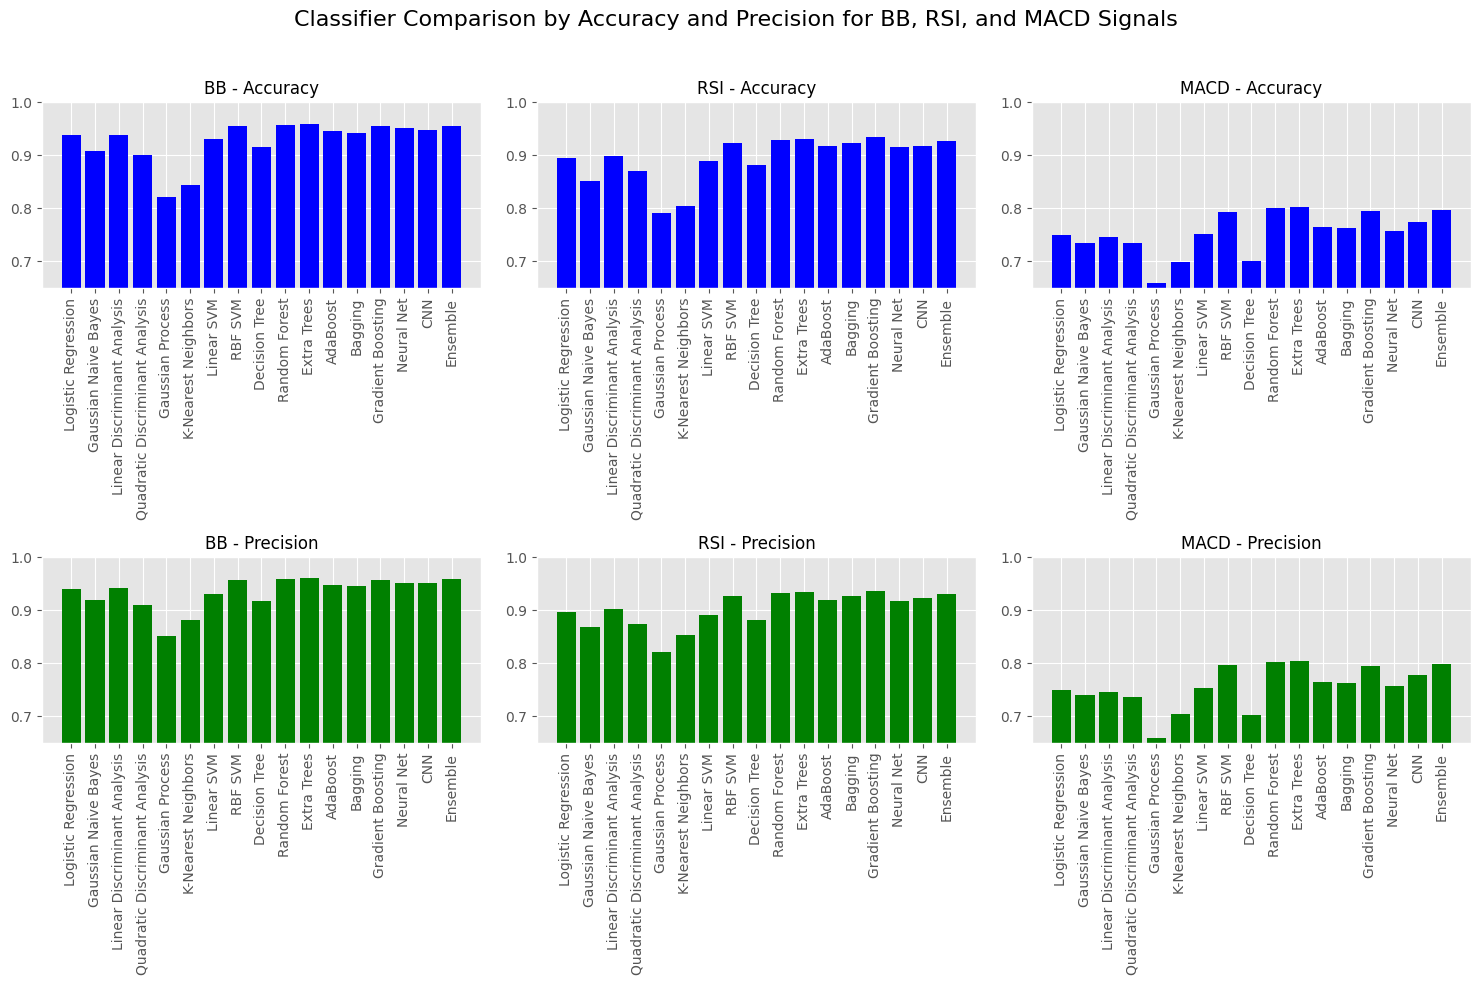

In [33]:
plot_accuracy_precision_with_custom_style(all_results)

Multiple conclusions can be drawn from the above graph:

1) We get similar results as the one from the paper, i.e for the accuracy and the precision, we get a score of roughly 90%-95% for the RSI and the BB signals, and a score of 80% for the MACD signal.
2) The differences of results between the different classifiers are relatively small. Although the Quadratic Discriminator Analysis, teh Gaussian Process, and the K-nearest neighbors seems to do consistently worse than the other classifiers.
3) Although the ensemble method (majority voting of all the classifiers) seems to be working well, it does not seem that it is a necessary technique. Indeed, every single time, we get as good of an accuracy and of a precision simply by using the Extra Trees method or the Gradient Boosting.

Using the conclusion number 3), from now on, we will only train our model using Gradient Boosting, which will allow us to gain some training time.

In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import pickle

def process_and_classify_images(tickers_data, start_date, end_date, output_dir, size=(30, 30)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images_by_indicator = {'BB': [], 'RSI': [], 'MACD': []}
    labels_by_indicator = {'BB': [], 'RSI': [], 'MACD': []}

    for ticker, data in tickers_data.items():
        data = data[(data.index >= start_date) & (data.index <= end_date)]
        labels_buy = generate_labels(data)  
        labels_sell = generate_sell_labels(data) 
        
        for i in range(len(data)):
            window = data.iloc[max(0, i - 30):i + 1]
            if len(window) < 30:
                continue  

            image = create_candlestick_image(window, size=size)

            for indicator in ['BB', 'RSI', 'MACD']:
                signal_buy = labels_buy[indicator].iloc[i]
                signal_sell = labels_sell[indicator].iloc[i]
                
                # Sauvegarder l'image dans le répertoire avec un nom descriptif
                if signal_buy == 1:
                    signal_label = 'buy'
                elif signal_sell == 1:
                    signal_label = 'sell'
                else:
                    signal_label = 'no_signal'

                filename = f"{ticker}_{indicator}_{signal_label}_{data.index[i].strftime('%Y-%m-%d')}.png"
                filepath = os.path.join(output_dir, filename)

                # Sauvegarder l'image
                plt.imsave(filepath, image, cmap='gray')

                # Classer l'image selon le signal
                images_by_indicator[indicator].append(image)
                labels_by_indicator[indicator].append(signal_label)

    return images_by_indicator, labels_by_indicator

# Entraîner le modèle de Gradient Boosting
def train_gradient_boosting(X_train, y_train, X_val, y_val, X_test, y_test):
    model = GradientBoostingClassifier()

    # Aplatir les images pour le modèle
    X_train = np.array([x.flatten() for x in X_train])
    X_val = np.array([x.flatten() for x in X_val])
    X_test = np.array([x.flatten() for x in X_test])

    model.fit(X_train, y_train)
    predictions_val = model.predict(X_val)
    predictions_test = model.predict(X_test)

    print("Validation set performance:")
    print(classification_report(y_val, predictions_val))
    
    print("Test set performance:")
    print(classification_report(y_test, predictions_test))
    
    return model

# Séparer les données selon les dates
def split_data_by_dates(tickers_data, train_start, train_end, val_start, val_end, test_start, test_end):
    train_data = {}
    val_data = {}
    test_data = {}

    for ticker, data in tickers_data.items():
        train_data[ticker] = data[(data.index >= train_start) & (data.index <= train_end)]
        val_data[ticker] = data[(data.index >= val_start) & (data.index <= val_end)]
        test_data[ticker] = data[(data.index >= test_start) & (data.index <= test_end)]

    return train_data, val_data, test_data

# Préparer les données (images et labels)
def prepare_data(images_by_indicator, labels_by_indicator):
    X = []
    y = []
    for img, label in zip(images_by_indicator, labels_by_indicator):
        X.append(img)
        y.append(label)
    return np.array(X), np.array(y)

In [18]:
three_stocks_data = get_data_batch(['AAPL', 'MSFT', 'GOOG'],'2010-01-01', '2019-12-31')

dict

In [22]:
import time

In [24]:

tickers_data = three_stocks_data


train_start = '2010-01-01'
train_end = '2014-12-31'
val_start = '2015-01-01'
val_end = '2017-12-31'
test_start = '2018-01-01'
test_end = '2019-12-31'


output_dir = '/Users/samykobbite/Documents/Berkeley/Term 3/Unsupervised Learning (ZB)'

time_1 = time.time()

train_data, val_data, test_data = split_data_by_dates(tickers_data, train_start, train_end, val_start, val_end, test_start, test_end)
time_2 = time.time()
print(time_2 - time_1)

images_train, labels_train = process_and_classify_images(train_data, train_start, train_end, output_dir)
time_3 = time.time()
print(time_3 - time_2)

images_val, labels_val = process_and_classify_images(val_data, val_start, val_end, output_dir)
time_4 = time.time()
print(time_4 - time_3)

images_test, labels_test = process_and_classify_images(test_data, test_start, test_end, output_dir)
time_5 = time.time()
print(time_5 - time_4)


0.0050449371337890625
127.26944518089294
443.86520195007324
54.597450971603394


In [26]:
models = {}

# Training Gradient Boosting for each indicator
for indicator in ['BB', 'RSI', 'MACD']:
    print(f"Training Gradient Boosting for {indicator} signals...")

    X_train, y_train = prepare_data(images_train[indicator], labels_train[indicator])
    X_val, y_val = prepare_data(images_val[indicator], labels_val[indicator])
    X_test, y_test = prepare_data(images_test[indicator], labels_test[indicator])

    model = train_gradient_boosting(X_train, y_train, X_val, y_val, X_test, y_test)
    models[indicator] = model

output_model_dir = '/Users/samykobbite/Documents/Berkeley/Term 3/Unsupervised Learning (ZB)/trained_gradient_boosting_models.pkl'
with open(output_model_dir, 'wb') as f:
    pickle.dump(models, f)

print(f"Models succesfully saved in : {output_model_dir}")

Training Gradient Boosting for BB signals...
Validation set performance:
              precision    recall  f1-score   support

         buy       0.98      1.00      0.99      2096
   no_signal       0.85      0.40      0.55        82

    accuracy                           0.97      2178
   macro avg       0.91      0.70      0.77      2178
weighted avg       0.97      0.97      0.97      2178

Test set performance:
              precision    recall  f1-score   support

         buy       0.98      0.99      0.99      1376
   no_signal       0.62      0.30      0.41        43

    accuracy                           0.97      1419
   macro avg       0.80      0.65      0.70      1419
weighted avg       0.97      0.97      0.97      1419

Training Gradient Boosting for RSI signals...
Validation set performance:
              precision    recall  f1-score   support

         buy       0.97      0.99      0.98      2039
   no_signal       0.83      0.57      0.68       139

    accuracy 

In [28]:
model_file_path = '/Users/samykobbite/Documents/Berkeley/Term 3/Unsupervised Learning (ZB)/trained_gradient_boosting_models.pkl'

with open(model_file_path, 'rb') as f:
    loaded_models = pickle.load(f)

print("Model succesfully downloaded")

Model succesfully downloaded


In [114]:
def generate_test_set_signals(loaded_models, test_set_images, image_size=(30, 30)):
    """
    Generates signals (buy, sell, no_signal) for each stock and each indicator
    based on the loaded models and the test set images.
    
    :param loaded_models: A dictionary of loaded models (BB, RSI, MACD).
    :param test_set_images: A dictionary containing test set images for each stock.
                            {'BB': {'AAPL': [img1, img2, ...], 'MSFT': ...}, 'RSI': ...}
    :param image_size: Size to which images should be resized (default 30x30).
    
    :return: A dictionary with generated signals for each indicator and each stock.
             {'BB': {'AAPL': ['buy', 'sell', 'no_signal', ...], 'MSFT': ...}, 'RSI': ...}
    """
    bb_signals = {}
    rsi_signals = {}
    macd_signals = {}
    
    for indicator in ['BB', 'RSI', 'MACD']:
        model = loaded_models[indicator]  # Récupérer le modèle pré-entraîné pour cet indicateur
        
        print(f"Classes utilisées pour {indicator}: {model.classes_}")
        
        for action in test_set_images[indicator]:
            images = test_set_images[indicator][action]
            
            # Redimensionner les images à la taille attendue et les convertir en niveaux de gris
            resized_images = [Image.fromarray(img).convert('L').resize(image_size) for img in images]
            
            # Aplatir les images pour les passer dans le modèle
            X_test = np.array([np.array(img).flatten() for img in resized_images])
            
            # Faire des prédictions
            predictions = model.predict(X_test)
            
            # Convertir les prédictions en labels (1 pour 'buy', -1 pour 'sell', 0 pour 'no_signal')
            signals = []
            for pred in predictions:
                if pred == 'buy':
                    signals.append(1)
                elif pred == 'sell':
                    signals.append(-1)
                else:
                    signals.append(0)
            
            # Stocker les signaux dans les bons dictionnaires pour chaque action
            if indicator == 'BB':
                bb_signals[action] = signals
            elif indicator == 'RSI':
                rsi_signals[action] = signals
            elif indicator == 'MACD':
                macd_signals[action] = signals
    
    return bb_signals, rsi_signals, macd_signals

In [32]:
import re

In [64]:
def load_test_set_images(directory, start_date, end_date):
    """
    Loads test set images based on dates and organizes them by stock and indicator.
    
    :param directory: Path to the directory where images are stored.
    :param start_date: Start date of the test set (format 'YYYY-MM-DD').
    :param end_date: End date of the test set (format 'YYYY-MM-DD').
    
    :return: A dictionary organized by indicator and then by stock.
             Example: {'BB': {'AAPL': [img1, img2, ...], 'MSFT': ...}, 'RSI': ...}
    """
    test_set_images = {'BB': {}, 'RSI': {}, 'MACD': {}}
    
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    
    for filename in os.listdir(directory):
        if filename.endswith('.png'):  
            match = re.match(r"([A-Z]+)_([A-Z]+)_(buy|sell|no_signal)_(\d{4}-\d{2}-\d{2})\.png", filename)
            if match:
                ticker, indicator, signal, date_str = match.groups()
                image_date = pd.to_datetime(date_str)
                
                
                if start_date <= image_date <= end_date:
                    
                    filepath = os.path.join(directory, filename)
                    image = Image.open(filepath)
                    image = np.array(image)  

                    
                    if ticker not in test_set_images[indicator]:
                        test_set_images[indicator][ticker] = []
                    test_set_images[indicator][ticker].append(image)
                    
    return test_set_images

In [41]:

image_directory = '/Users/samykobbite/Documents/Berkeley/Term 3/Unsupervised Learning (ZB)/Three_images'

test_start_date = '2018-01-01'
test_end_date = '2019-12-31'

test_set_images = load_test_set_images(image_directory, test_start_date, test_end_date)

for indicator in test_set_images:
    for action in test_set_images[indicator]:
        print(f"{indicator} - {action}: {len(test_set_images[indicator][action])} images")

BB - MSFT: 473 images
BB - GOOG: 473 images
BB - AAPL: 473 images
RSI - AAPL: 473 images
RSI - MSFT: 473 images
RSI - GOOG: 473 images
MACD - MSFT: 473 images
MACD - GOOG: 473 images
MACD - AAPL: 473 images


Example image

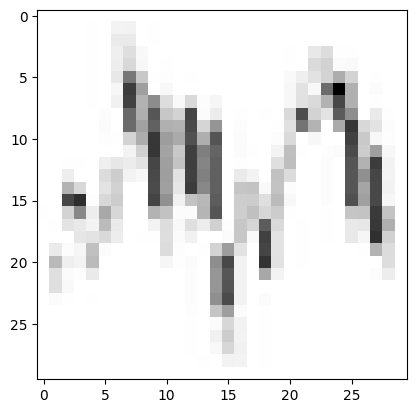

In [76]:
img_array = test_set_images['BB']['MSFT'][0]  
plt.imshow(img_array, cmap='gray')
plt.show()

Example image dimensions

In [77]:
image = test_set_images['BB']['MSFT'][0]  # Exemple avec la première image de BB pour MSFT
print(f"Taille de l'image : {image.shape}")

Taille de l'image : (30, 30, 4)


In [126]:
len(generate_test_set_signals(loaded_models, test_set_images)[1]['GOOG'])

Classes utilisées pour BB: ['buy' 'no_signal']
Classes utilisées pour RSI: ['buy' 'no_signal']
Classes utilisées pour MACD: ['buy' 'no_signal' 'sell']


473

In [184]:
def apply_trading_strategy(bb_signals, rsi_signals, macd_signals, test_set_prices, initial_capital=100, risk_free_rate=0.02):
    days = test_set_prices.index
    actions = test_set_prices.columns

    
    returns = test_set_prices.pct_change().fillna(0)  
    
    min_length = min(len(days), len(next(iter(bb_signals.values()))), len(next(iter(rsi_signals.values()))), len(next(iter(macd_signals.values()))))
    days = days[:min_length]
    returns = returns.iloc[:min_length]  

    capital = initial_capital
    portfolio_values = []
    positions = {action: [0] * min_length for action in actions}  
    risk_free_position = [capital]  
    portfolio_weights = {action: [0] * min_length for action in actions}  
    risk_free_weights = [1] * min_length  

    days_since_sell = {action: -np.inf for action in actions}

    for i, day in enumerate(days):
        tradable_actions = []
        buy_signals_count = {action: 0 for action in actions}

        for action in actions:
            if i - days_since_sell[action] < 4: 
                positions[action][i] = 0  
            else:
                
                buy_signals_last_5_days = sum([
                    bb_signals[action][j] == 1 or 
                    rsi_signals[action][j] == 1 or 
                    macd_signals[action][j] == 1 
                    for j in range(max(0, i - 4), i + 1)
                ])
                buy_signals_count[action] = buy_signals_last_5_days

                
                if bb_signals[action][i] == -1 or rsi_signals[action][i] == -1 or macd_signals[action][i] == -1:
                    days_since_sell[action] = i
                    positions[action][i] = 0  
                else:
                    tradable_actions.append(action)

        
        if tradable_actions:
            total_buy_signals = sum(buy_signals_count[action] for action in tradable_actions)
            if total_buy_signals > 0:
    
                total_weight_used = 0
                for action in tradable_actions:
                    ratio = buy_signals_count[action] / total_buy_signals if total_buy_signals > 0 else 0
                    weight = ratio  
                    portfolio_weights[action][i] = weight
                    total_weight_used += weight
                
                risk_free_weights[i] = 1 - total_weight_used
            else:
                risk_free_weights[i] = 1
                for action in actions:
                    portfolio_weights[action][i] = 0
        else:
            risk_free_weights[i] = 1
            for action in actions:
                portfolio_weights[action][i] = 0

        if i > 0:
            daily_return = sum(
                portfolio_weights[action][i] * returns[action].iloc[i]
                for action in actions
            )
        else:
            daily_return = 0  

        
        risk_free_return = risk_free_weights[i] * (1 + risk_free_rate / 365 - 1)  
        total_daily_return = daily_return + risk_free_return

        
        portfolio_value = (portfolio_values[-1] if portfolio_values else capital) * (1 + total_daily_return)
        portfolio_values.append(portfolio_value)

    
    portfolio_weights_df = pd.DataFrame(portfolio_weights, index=days)
    portfolio_values_df = pd.DataFrame({'Portfolio Value': portfolio_values}, index=days)

    return portfolio_weights_df, portfolio_values_df

In [86]:
def generate_test_set_prices(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    closing_prices = data['Adj Close'] if 'Adj Close' in data.columns else data['Close']
    closing_prices.columns = tickers
    return closing_prices


{'BB': GradientBoostingClassifier(),
 'RSI': GradientBoostingClassifier(),
 'MACD': GradientBoostingClassifier()}

In [148]:
def generate_test_set_prices(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    closing_prices = data['Adj Close'] if 'Adj Close' in data.columns else data['Close']
    closing_prices.columns = tickers
    return closing_prices

In [163]:
three_stocks_tickers = ['MSFT', 'GOOG','AAPL']

test_set_prices = generate_test_set_prices(three_stocks_tickers, test_start_date, test_end_date)
test_set_prices

[*********************100%***********************]  3 of 3 completed


,MSFT,GOOG,AAPL
Date,,,
2018-01-02 00:00:00+00:00,40.568932,53.119549,79.792900
2018-01-03 00:00:00+00:00,40.561871,53.991409,80.164253
2018-01-04 00:00:00+00:00,40.750263,54.186924,80.869820
2018-01-05 00:00:00+00:00,41.214222,54.976486,81.872452
2018-01-08 00:00:00+00:00,41.061161,55.211411,81.955986
...,...,...,...
2019-12-23 00:00:00+00:00,68.909004,67.276779,150.861786
2019-12-24 00:00:00+00:00,68.974503,67.013435,150.833008
2019-12-26 00:00:00+00:00,70.342972,67.853363,152.069336


Apply trading strategy and generate signals

Classes utilisées pour BB: ['buy' 'no_signal']
Classes utilisées pour RSI: ['buy' 'no_signal']
Classes utilisées pour MACD: ['buy' 'no_signal' 'sell']


<Axes: xlabel='Date'>

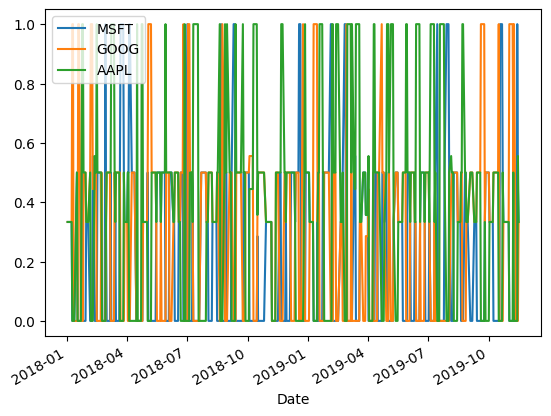

In [185]:
bb_signals , rsi_signals , macd_signals = generate_test_set_signals(loaded_models, test_set_images)
apply_trading_strategy(bb_signals , rsi_signals , macd_signals,test_set_prices)[0].plot()

<Axes: xlabel='Date'>

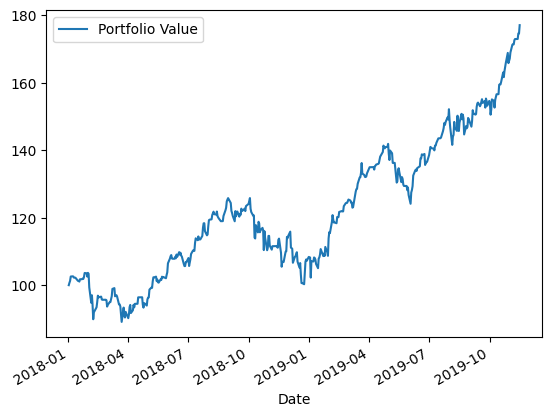

In [186]:
apply_trading_strategy(bb_signals , rsi_signals , macd_signals,test_set_prices)[1].plot()

In [187]:
def buy_and_hold_strategy(test_set_prices, initial_capital=100):
    days = test_set_prices.index
    actions = test_set_prices.columns

    
    returns = test_set_prices.pct_change().fillna(0)  

    equal_weight = 1 / len(actions)
    initial_position = {action: (initial_capital * equal_weight) / test_set_prices[action].iloc[0] for action in actions}  # Nombre d'actions achetées au jour 0

    portfolio_values = []

    for i, day in enumerate(days):
    
        portfolio_value = sum(
            initial_position[action] * test_set_prices[action].iloc[i]
            for action in actions
        )
        portfolio_values.append(portfolio_value)

    portfolio_values_df = pd.DataFrame({'Portfolio Value': portfolio_values}, index=days)

    return portfolio_values_df

<Axes: xlabel='Date'>

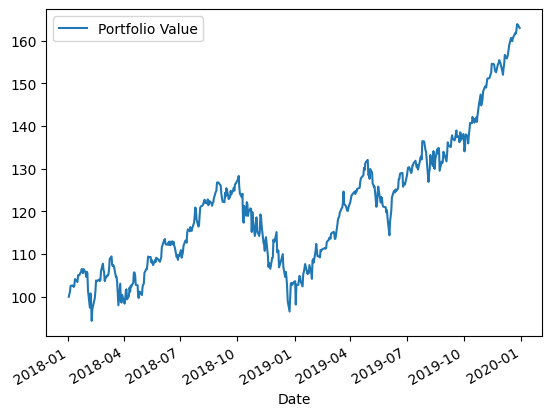

In [188]:
buy_and_hold_results = buy_and_hold_strategy(test_set_prices, initial_capital=100)

buy_and_hold_results.plot()

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_portfolio_comparison(strategy1_values, strategy2_values, labels, title="Portfolio Value Comparison"):
    sns.set(style="whitegrid")  # Set a clean style using seaborn

    plt.figure(figsize=(12, 8))

    # Plot both portfolio values
    plt.plot(strategy1_values.index, strategy1_values['Portfolio Value'], label=labels[0], color='blue', linewidth=2)
    plt.plot(strategy2_values.index, strategy2_values['Portfolio Value'], label=labels[1], color='orange', linewidth=2)

    # Adding titles and labels
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Portfolio Value', fontsize=14)

    # Adding grid, legend and aesthetic touches
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc="upper left", fontsize=12, frameon=True, shadow=True, title="Strategies")
    plt.xticks(rotation=45)
    
    # Set the background color
    plt.gca().set_facecolor('whitesmoke')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

In [190]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [195]:
from tabulate import tabulate
import matplotlib.pyplot as plt

def create_performance_table(metrics_comparison, labels):
    # Convert DataFrame to list format for tabulate
    headers = ["Metric", labels[0], labels[1]]
    
    # Ensure all values are floats and format them as percentages
    data = [[metric, f"{float(metrics_comparison[labels[0]][metric]):.2%}", 
             f"{float(metrics_comparison[labels[1]][metric]):.2%}"] 
            for metric in metrics_comparison.index]

    # Create a table with tabulate
    table_str = tabulate(data, headers, tablefmt="fancy_grid")

    # Display the table in matplotlib
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')

    # Add the table as an image in the plot
    plt.table(cellText=data, colLabels=headers, cellLoc='center', loc='center', colWidths=[0.2, 0.15, 0.15])
    
    # Display the table
    plt.tight_layout()
    plt.show()

    return table_str

In [192]:
import numpy as np

def calculate_performance_metrics(portfolio_values, risk_free_rate=0.02):
    daily_returns = portfolio_values.pct_change().fillna(0)
    annualized_return = (1 + daily_returns.mean())**252 - 1  # 252 jours de trading par an
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Maximum drawdown calculation
    cumulative_returns = (1 + daily_returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdowns = cumulative_returns / rolling_max - 1
    max_drawdown = drawdowns.min()

    # Sortino Ratio (downside volatility)
    downside_returns = daily_returns[daily_returns < 0]
    downside_volatility = downside_returns.std() * np.sqrt(252)
    sortino_ratio = (annualized_return - risk_free_rate) / downside_volatility

    # Calmar Ratio
    calmar_ratio = annualized_return / abs(max_drawdown)

    metrics = {
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio
    }

    return metrics

In [193]:
import pandas as pd

def compare_strategies_metrics(strategy1_values, strategy2_values, labels):
    metrics1 = calculate_performance_metrics(strategy1_values)
    metrics2 = calculate_performance_metrics(strategy2_values)

    comparison_df = pd.DataFrame({
        labels[0]: metrics1,
        labels[1]: metrics2
    })

    # Affichage du tableau
    print(comparison_df)
    return comparison_df

Compare both portfolios

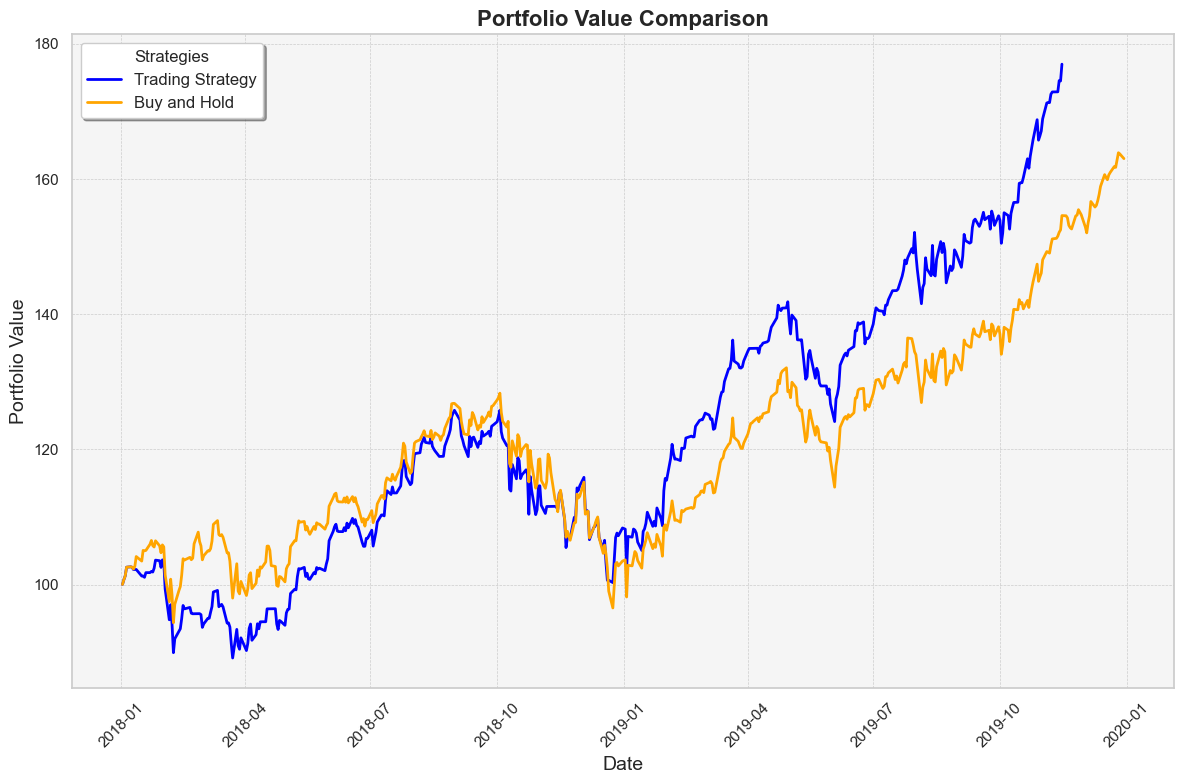

                                                 Trading Strategy  \
Annualized Return      Portfolio Value    0.392645
dtype: float64   
Annualized Volatility  Portfolio Value    0.232358
dtype: float64   
Sharpe Ratio            Portfolio Value    1.60375
dtype: float64   
Max Drawdown           Portfolio Value   -0.202823
dtype: float64   
Sortino Ratio          Portfolio Value    1.978661
dtype: float64   
Calmar Ratio           Portfolio Value    1.935902
dtype: float64   

                                                     Buy and Hold  
Annualized Return      Portfolio Value    0.312169
dtype: float64  
Annualized Volatility  Portfolio Value    0.229571
dtype: float64  
Sharpe Ratio           Portfolio Value    1.272675
dtype: float64  
Max Drawdown           Portfolio Value   -0.247712
dtype: float64  
Sortino Ratio           Portfolio Value    1.66066
dtype: float64  
Calmar Ratio           Portfolio Value    1.260211
dtype: float64  


/var/folders/7w/1lbxljld7gn3s8__s3ky_nx00000gn/T/ipykernel_6847/4157865207.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data = [[metric, f"{float(metrics_comparison[labels[0]][metric]):.2%}",
/var/folders/7w/1lbxljld7gn3s8__s3ky_nx00000gn/T/ipykernel_6847/4157865207.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  f"{float(metrics_comparison[labels[1]][metric]):.2%}"]


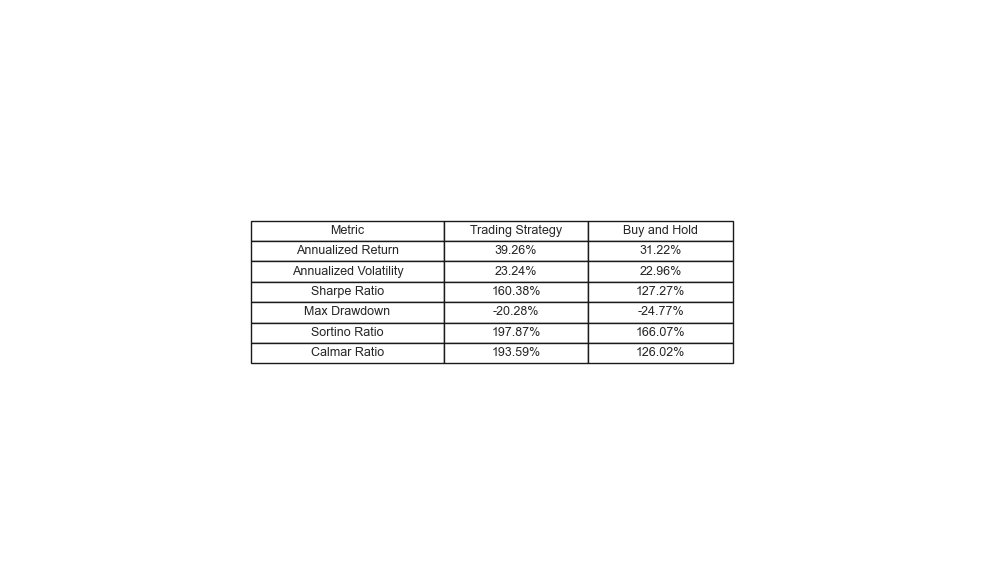

'╒═══════════════════════╤════════════════════╤════════════════╕\n│ Metric                │ Trading Strategy   │ Buy and Hold   │\n╞═══════════════════════╪════════════════════╪════════════════╡\n│ Annualized Return     │ 39.26%             │ 31.22%         │\n├───────────────────────┼────────────────────┼────────────────┤\n│ Annualized Volatility │ 23.24%             │ 22.96%         │\n├───────────────────────┼────────────────────┼────────────────┤\n│ Sharpe Ratio          │ 160.38%            │ 127.27%        │\n├───────────────────────┼────────────────────┼────────────────┤\n│ Max Drawdown          │ -20.28%            │ -24.77%        │\n├───────────────────────┼────────────────────┼────────────────┤\n│ Sortino Ratio         │ 197.87%            │ 166.07%        │\n├───────────────────────┼────────────────────┼────────────────┤\n│ Calmar Ratio          │ 193.59%            │ 126.02%        │\n╘═══════════════════════╧════════════════════╧════════════════╛'

In [196]:
apply_trading_results = apply_trading_strategy(bb_signals, rsi_signals, macd_signals, test_set_prices)
buy_and_hold_results = buy_and_hold_strategy(test_set_prices)

plot_portfolio_comparison(apply_trading_results[1], buy_and_hold_results, labels=["Trading Strategy", "Buy and Hold"])

metrics_comparison = compare_strategies_metrics(apply_trading_results[1], buy_and_hold_results, labels=["Trading Strategy", "Buy and Hold"])

create_performance_table(metrics_comparison, labels=["Trading Strategy", "Buy and Hold"])

                                                 Trading Strategy  \
Annualized Return      Portfolio Value    0.392645
dtype: float64   
Annualized Volatility  Portfolio Value    0.232358
dtype: float64   
Sharpe Ratio            Portfolio Value    1.60375
dtype: float64   
Max Drawdown           Portfolio Value   -0.202823
dtype: float64   
Sortino Ratio          Portfolio Value    1.978661
dtype: float64   
Calmar Ratio           Portfolio Value    1.935902
dtype: float64   

                                                     Buy and Hold  
Annualized Return      Portfolio Value    0.312169
dtype: float64  
Annualized Volatility  Portfolio Value    0.229571
dtype: float64  
Sharpe Ratio           Portfolio Value    1.272675
dtype: float64  
Max Drawdown           Portfolio Value   -0.247712
dtype: float64  
Sortino Ratio           Portfolio Value    1.66066
dtype: float64  
Calmar Ratio           Portfolio Value    1.260211
dtype: float64  


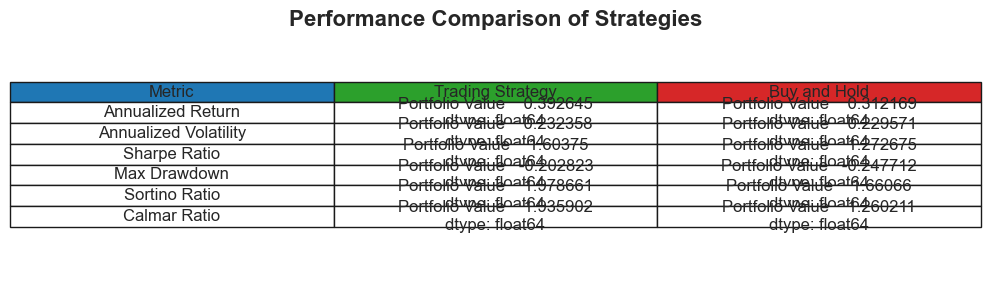

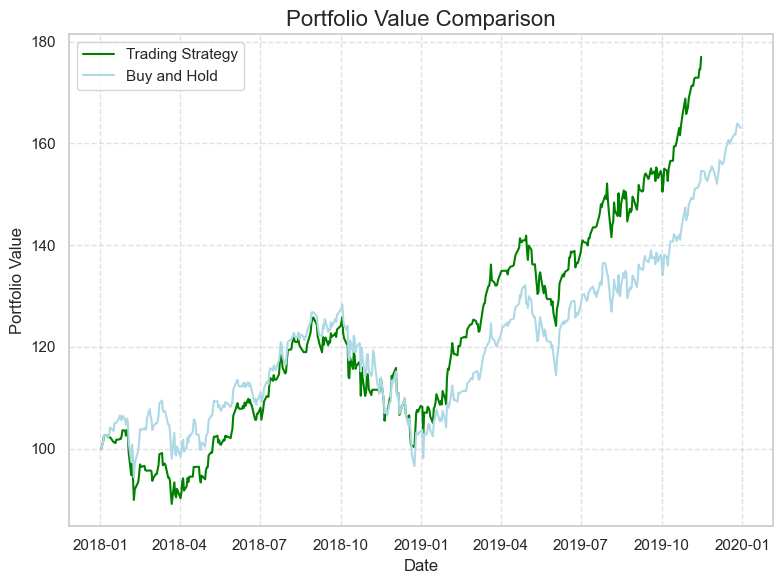

                                                 Trading Strategy  \
Annualized Return      Portfolio Value    0.392645
dtype: float64   
Annualized Volatility  Portfolio Value    0.232358
dtype: float64   
Sharpe Ratio            Portfolio Value    1.60375
dtype: float64   
Max Drawdown           Portfolio Value   -0.202823
dtype: float64   
Sortino Ratio          Portfolio Value    1.978661
dtype: float64   
Calmar Ratio           Portfolio Value    1.935902
dtype: float64   

                                                     Buy and Hold  
Annualized Return      Portfolio Value    0.312169
dtype: float64  
Annualized Volatility  Portfolio Value    0.229571
dtype: float64  
Sharpe Ratio           Portfolio Value    1.272675
dtype: float64  
Max Drawdown           Portfolio Value   -0.247712
dtype: float64  
Sortino Ratio           Portfolio Value    1.66066
dtype: float64  
Calmar Ratio           Portfolio Value    1.260211
dtype: float64  


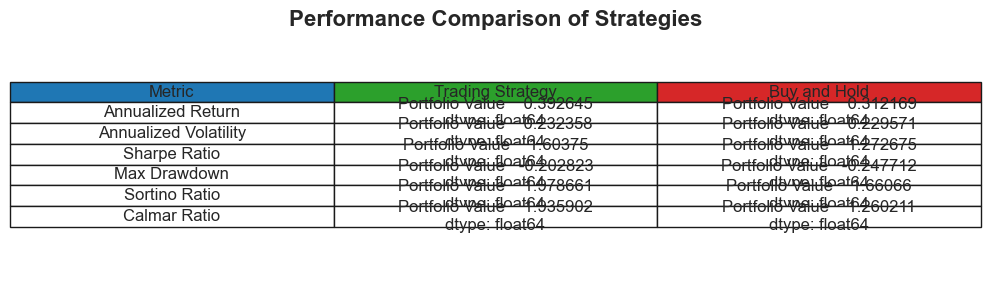

In [205]:
import matplotlib.pyplot as plt
from matplotlib import style
from tabulate import tabulate
import seaborn as sns
import pandas as pd

# Function to plot portfolio returns comparison
def plot_portfolio_returns(apply_trading_results, buy_and_hold_results):
    plt.figure(figsize=(8, 6))  # Adjust size
    plt.plot(apply_trading_results.index, apply_trading_results['Portfolio Value'], color='green', linewidth=1.5, label='Trading Strategy')
    plt.plot(buy_and_hold_results.index, buy_and_hold_results['Portfolio Value'], color='lightblue', linewidth=1.5, label='Buy and Hold')
    plt.title('Portfolio Value Comparison', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Portfolio Value', fontsize=12)
    plt.legend(loc="upper left")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def create_performance_table(metrics_comparison, labels):
    # Convert the metrics comparison dictionary into a DataFrame
    table_df = pd.DataFrame(metrics_comparison)

    # Ensure that there are exactly two columns for the comparison
    if table_df.shape[1] != len(labels):
        raise ValueError(f"Expected {len(labels)} columns, but got {table_df.shape[1]}.")

    # Rename the columns with the strategy labels
    table_df.columns = labels

    # Create a figure for the table
    fig, ax = plt.subplots(figsize=(10, 3))  # Adjust the size of the table
    ax.axis('tight')
    ax.axis('off')

    # Create the table with custom style using matplotlib's table method
    table_data = table_df.reset_index().values
    col_labels = ["Metric"] + list(table_df.columns)
    table = ax.table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='center', colColours=["#1f77b4", "#2ca02c", "#d62728"])

    # Set the font size and the layout
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)  # Make the table bigger

    # Display the table
    plt.title('Performance Comparison of Strategies', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example of how you'd use these functions:
# Assume `metrics_comparison` is already calculated
metrics_comparison = compare_strategies_metrics(apply_trading_results[1], buy_and_hold_results, labels=["Trading Strategy", "Buy and Hold"])

# Create the professional table
create_performance_table(metrics_comparison, labels=["Trading Strategy", "Buy and Hold"])

# Example of how you'd use these functions:
# Compare the portfolio performance metrics and plot the results
plot_portfolio_returns(apply_trading_results[1], buy_and_hold_results)

metrics_comparison = compare_strategies_metrics(apply_trading_results[1], buy_and_hold_results, labels=["Trading Strategy", "Buy and Hold"])

# Create the colorful table
create_performance_table(metrics_comparison, labels=["Trading Strategy", "Buy and Hold"])